In [ ]:
! pip install -q kaggle
from google.colab import files

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permission
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
corn-or-maize-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Import library yang dibutuhkan
!pip install split-folders
import splitfolders
import tensorflow as tf
import zipfile,os
import pandas as pd
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# Ekstrak Dataset
local_zip = '/content/corn-or-maize-leaf-disease-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

base_dir = '/content/corn_leaf_disease_splitted'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
# Membuat input folder dan output folder
input_folder ='/content/data'
output_folder='/content/corn_leaf_disease_splitted'

In [ ]:
# Splitfolder
splitfolders.ratio(input_folder, output=output_folder, seed=51, ratio=(.6, .4), group_prefix=None)

Copying files: 4188 files [00:01, 3267.10 files/s]


In [ ]:
os.listdir('/content/corn_leaf_disease_splitted/train')

['Healthy', 'Gray_Leaf_Spot', 'Common_Rust', 'Blight']

In [ ]:
os.listdir('/content/corn_leaf_disease_splitted/val')

['Healthy', 'Gray_Leaf_Spot', 'Common_Rust', 'Blight']

In [ ]:
# Menampilkan jumlah gambar di setiap kategori
train_folder = '/content/corn_leaf_disease_splitted/train/'

blight = glob(train_folder + 'Blight/*.JPG') + glob(train_folder + 'Blight/*.jpg')

common_rust = glob(train_folder + 'Common_Rust/*.JPG') + glob(train_folder + 'Common_Rust/*.jpg')

gray_leaf = glob(train_folder + 'Gray_Leaf_Spot/*.JPG') + glob(train_folder + 'Gray_Leaf_Spot/*.jpg')

healthy = glob(train_folder + 'Healthy/*.JPG') + glob(train_folder + 'Healthy/*.jpg')

print("Jumlah gambar blight:", len(blight))
print("Jumlah gambar common rust:", len(common_rust))
print("Jumlah gambar gray leaf:", len(gray_leaf))
print("Jumlah gambar healthy:", len(healthy))

Jumlah gambar blight: 686
Jumlah gambar common rust: 783
Jumlah gambar gray leaf: 344
Jumlah gambar healthy: 697


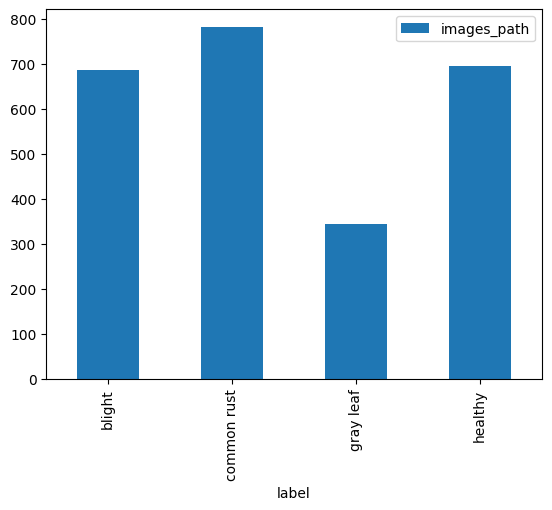

In [ ]:
# Menggabungkan semua path gambar dari ketiga kategori
all_images = blight + common_rust + gray_leaf + healthy

# Membuat DataFrame dengan kolom 'images_path'
df = pd.DataFrame({'images_path': all_images})

# Menambahkan kolom 'label' berdasarkan kategori gambar
df['label'] = ''

# Mengisi kolom 'label' berdasarkan kategori gambar
for idx, image_path in enumerate(all_images):
    if image_path in blight:
        df.at[idx, 'label'] = 'blight'
    elif image_path in common_rust:
        df.at[idx, 'label'] = 'common rust'
    elif image_path in gray_leaf:
        df.at[idx, 'label'] = 'gray leaf'
    elif image_path in healthy:
        df.at[idx, 'label'] = 'healthy'

df.groupby('label').count().plot.bar()
plt.show()

<ipython-input-94-f94030ed78ee>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, i+1)  # Mengubah menjadi 1 baris dengan 4 kolom


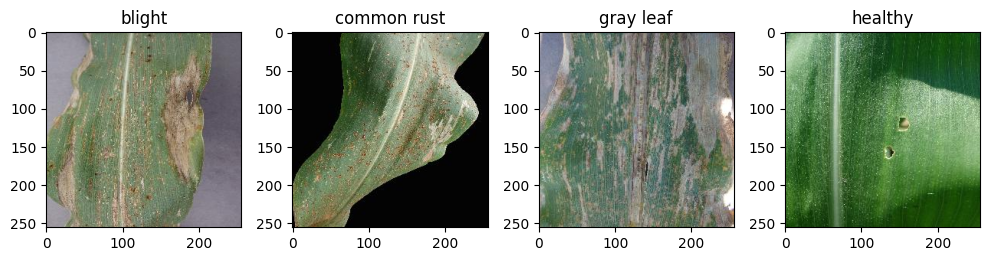

In [ ]:
# Menampilkan sampel kategori gambar
plt.subplots(figsize=(10, 6))

categories = ['blight', 'common rust', 'gray leaf', 'healthy']

# Sesuaikan jumlah subplot dengan jumlah kategori
for i, category in enumerate(categories):
    plt.subplot(1, 4, i+1)  # Mengubah menjadi 1 baris dengan 4 kolom
    x = df[df['label'] == category]['images_path']

    # Cek apakah ada gambar yang sesuai dengan kategori
    if not x.empty:
        path = x.values[0]
        img = plt.imread(path)
        plt.imshow(img)
        plt.title(category)
    else:
        plt.text(0.5, 0.5, 'No image', horizontalalignment='center', verticalalignment='center')
        plt.title(f'{category} (No data)')

plt.tight_layout()  # Agar subplot tidak tumpang tindih
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(224, 224),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        # karena ini merupakan masalah klasifikasi 4 kelas, maka menggunakan class_mode = 'categorical'
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(224, 224), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32, # karena ini merupakan masalah klasifikasi 4 kelas gunakan class_mode = 'categorical'
        class_mode='categorical')

Found 2511 images belonging to 4 classes.
Found 1677 images belonging to 4 classes.


In [ ]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │      37,749,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,434,884 (146.62 MB)

 Trainable params: 38,434,884 (146.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model dengan 'Adam' optimizer loss function 'categorical_crossentropy'
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy']
              )

In [ ]:
# callbacks EarlyStopping
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    verbose=1,
    restore_best_weights='True'
)

Tensor_Board = tf.keras.callbacks.TensorBoard('tensorboard_logs')

In [ ]:
model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=30, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks=[Early_Stopping, Tensor_Board])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 - 27s - 1s/step - accuracy: 0.5562 - loss: 1.0743 - val_accuracy: 0.8000 - val_loss: 0.6614
Epoch 2/30
25/25 - 13s - 524ms/step - accuracy: 0.7535 - loss: 0.6229 - val_accuracy: 0.8125 - val_loss: 0.4680
Epoch 3/30
25/25 - 9s - 349ms/step - accuracy: 0.8112 - loss: 0.4752 - val_accuracy: 0.6812 - val_loss: 0.6436
Epoch 4/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 - 0s - 19ms/step - accuracy: 0.7500 - loss: 0.4358 - val_accuracy: 0.7188 - val_loss: 0.5633
Epoch 5/30
25/25 - 16s - 637ms/step - accuracy: 0.8037 - loss: 0.4555 - val_accuracy: 0.8000 - val_loss: 0.4362
Epoch 6/30
25/25 - 11s - 440ms/step - accuracy: 0.8138 - loss: 0.4481 - val_accuracy: 0.8313 - val_loss: 0.4097
Epoch 7/30
25/25 - 10s - 408ms/step - accuracy: 0.8161 - loss: 0.4180 - val_accuracy: 0.8125 - val_loss: 0.4279
Epoch 8/30
25/25 - 1s - 24ms/step - accuracy: 0.8438 - loss: 0.4110 - val_accuracy: 0.8188 - val_loss: 0.3684
Epoch 9/30
25/25 - 18s - 717ms/step - accuracy: 0.8199 - loss: 0.4675 - val_accuracy: 0.7812 - val_loss: 0.5925
Epoch 10/30
25/25 - 13s - 501ms/step - accuracy: 0.8062 - loss: 0.4499 - val_accuracy: 0.8062 - val_loss: 0.4725
Epoch 11/30
25/25 - 11s - 425ms/step - accuracy: 0.7975 - loss: 0.4385 - val_accuracy: 0.7922 - val_loss: 0.5503
Epoch 12/30
25/25 - 1s - 25ms/step - accuracy: 0.8438 - loss: 0.2885 - val_accuracy: 0.8438 - val_loss: 0.4315
Epoch 

Saving Corn_Blight (531).JPG to Corn_Blight (531).JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Corn_Blight (531).JPG
Blight


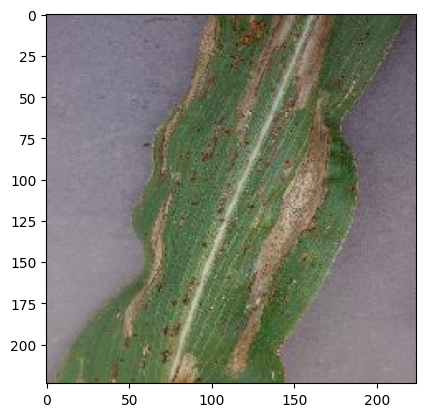

In [ ]:
# Memprediksi gambar
uploaded = files.upload()

for fn in uploaded.keys():
  # Memuat gambar dan mengubah ukuran menjadi (150,150)
  path = fn
  img = image.load_img(path, target_size=(224,224))

  # Menampilkan gambar
  imgplot = plt.imshow(img)

  # Mengubah gambar menjadi array dan menyiapkan input untuk model
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  images = np.vstack([x])

  # Melakukan prediksi
  classes = model.predict(images, batch_size=10)
  print(fn)

  # Mendapatkan prediksi dengan nilai argmax (kelas yang memiliki nilai prediksi tertinggi)
  predict = np.argmax(classes)

  # Menyesuaikan kategori prediksi sesuai dengan 4 kelas
  if predict == 0:
    print('Blight')
  elif predict == 1:
    print('Common Rust')
  elif predict == 2:
    print('Gray Leaf')
  elif predict == 3:
    print('Healthy')
  else:
    print('Unknown')

In [ ]:
model.save('corn_disease_model.h5')